
# ISIC 2018 — U-Net++ Segmentation Workflow
This notebook refers to the initial setup (environment, paths, dependencies) and the later evaluation (Dice/IoU, visualization) sections, rewritten as the end-to-end workflow for the U‑Net++ model: data loading → training → validation → test set evaluation and visualization.

> Table of Contents:
> 1. Initial Setup (environment and dependencies, paths, random seed, devices)
> 2. Data Preparation (directory structure, Dataset, Transforms, DataLoader)
> 3. Model (U‑Net++, loss function, optimizer, scheduler, AMP)
> 4. Training and Validation (saving the best model, logging)
> 5. Later Evaluation (calculating Dice/IoU on the test set, threshold selection, visualization)


## 1) Preliminary configuration
### 1.1）environment and dependency installation

In [ ]:
# Install dependencies
!pip -q install segmentation-models-pytorch==0.3.3 albumentations==1.4.8 torchmetrics==1.4.0 opencv-python==4.10.0.84
!pip -q install rich==13.7.1
!pip install -U albucore albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.8
    Uninstalling albumenta

### 1.2）Import dependencies, set paths and random seeds

In [ ]:
import os, random, time, math, json, shutil, glob, sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

try:
    from rich import print
except Exception:
    pass

# random seeds
DATA_ROOT = Path("/content/drive/MyDrive/BS6204/ISIC2018")
OUTPUT_DIR = Path("./outputs_unetpp_isic2018")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] -> {DEVICE}")


[Device] -> cuda

## 2) Data Preprocessing

In [ ]:
# Google Drive and Root path
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os, shutil, re, glob

DATA_ROOT = Path("/content/drive/MyDrive/BS6204/ISIC2018")
assert DATA_ROOT.exists(), f"DATA_ROOT does not exist：{DATA_ROOT}"

IMG_EXTS = {".png",".jpg",".jpeg",".tif",".tiff",".bmp"}

def _has_images(p: Path):
    if not p.exists() or not p.is_dir(): return False
    for ext in IMG_EXTS:
        if any(p.glob(f"*{ext}")):
            return True
    return False

def _guess_split_dirs(root: Path):
    candidates = list(root.glob("*"))
    names = [c.name for c in candidates if c.is_dir()]
    res = {}

    def pick_dirs(keyword_in, keyword_gt):
        in_dir = None; gt_dir = None
        for d in candidates:
            n = d.name.lower()
            if keyword_in in n and "input" in n and _has_images(d):
                in_dir = d
            if keyword_gt in n and ("groundtruth" in n or "mask" in n or "label" in n) and _has_images(d):
                gt_dir = d
        return in_dir, gt_dir

    # train
    tin, tgt = pick_dirs("training","training")
    if tin is not None and tgt is not None:
        res["train"] = (tin, tgt)

    # val
    vin, vgt = pick_dirs("validation","validation")
    if vin is not None and vgt is not None:
        res["val"] = (vin, vgt)

    # test
    qin, qgt = pick_dirs("test","test")
    if qin is not None:
        res["test"] = (qin, qgt if qgt is not None else None)

    return res

def _ensure_standard_layout(root: Path):

    std = {
        "train": (root/"train"/"Input", root/"train"/"GroundTruth"),
        "val":   (root/"val"/"Input",   root/"val"/"GroundTruth"),
        "test":  (root/"test"/"Input",  root/"test"/"GroundTruth"),
    }
    need_fix = any(not p.exists() for pair in std.values() for p in pair)

    if not need_fix:
        print("The standard directory already exists and does not need to be repaired.")
        return

    print("No standard directory structure detected, trying to automatically discover and create symbolic links...")
    mapping = _guess_split_dirs(root)
    if not mapping:
        raise FileNotFoundError(
            "No catalogues matching the ISIC 2018 common nomenclature were found.\n"
            f"Please confirm that the data has been unzipped to: {root}\n"
            "Or manually organize it as: train/Input, train/GroundTruth, val/Input, val/GroundTruth, test/Input[, test/GroundTruth]"
        )

    for split, (in_dir, gt_dir) in mapping.items():
        dst_in, dst_gt = std[split]
        dst_in.parent.mkdir(parents=True, exist_ok=True)
        dst_gt.parent.mkdir(parents=True, exist_ok=True)

        if not dst_in.exists():
            os.symlink(in_dir, dst_in)
        if gt_dir is not None and not dst_gt.exists():
            os.symlink(gt_dir, dst_gt)

        print(f" {split}:")
        print("   Input ->", in_dir)
        print("   GT    ->", gt_dir if gt_dir is not None else "(NA)")

_ensure_standard_layout(DATA_ROOT)

# Pair function
def _list_pairs(root_split: Path, mask_suffix="_segmentation"):
    img_dir  = root_split/"Input"
    mask_dir = root_split/"GroundTruth"
    if not img_dir.exists():
        raise FileNotFoundError(f"Input directory not found:{img_dir}\n Please confirm whether the above automatic repair is successful.")
    if not mask_dir.exists():
        return []

    def stem_key(p: Path):
        s = p.stem
        if s.endswith(mask_suffix):
            s = s[:-len(mask_suffix)]
        return s

    mask_index = {}
    for m in mask_dir.iterdir():
        if m.suffix.lower() in IMG_EXTS:
            mask_index[stem_key(m)] = m

    pairs = []
    for img in img_dir.iterdir():
        if img.suffix.lower() not in IMG_EXTS:
            continue
        key = img.stem
        if key in mask_index:
            pairs.append((img, mask_index[key]))
    return pairs

# Statistics and Validation
train_pairs = _list_pairs(DATA_ROOT/"train")
val_pairs   = _list_pairs(DATA_ROOT/"val")
test_pairs  = _list_pairs(DATA_ROOT/"test")

print(f"Pairs -> train: {len(train_pairs)} | val: {len(val_pairs)} | test: {len(test_pairs)}")
for name, pairs in [("train", train_pairs), ("val", val_pairs)]:
    print(f"Case {name}:")
    for i, (img, msk) in enumerate(pairs[:3]):
        print("  ", img.name, "<->", msk.name)


Mounted at /content/drive


✅ 标准目录已存在，无需修复。

Pairs -> train: 2594 | val: 100 | test: 1000

例子 train:

ISIC_0013275.jpg <-> ISIC_0013275_segmentation.png

ISIC_0013274.jpg <-> ISIC_0013274_segmentation.png

ISIC_0013277.jpg <-> ISIC_0013277_segmentation.png

例子 val:

ISIC_0012576.jpg <-> ISIC_0012576_segmentation.png

ISIC_0012255.jpg <-> ISIC_0012255_segmentation.png

ISIC_0012633.jpg <-> ISIC_0012633_segmentation.png

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE    = 256
BATCH_SIZE  = 8
NUM_WORKERS = 2

def get_train_tfms(size):
    return A.Compose([
        A.Resize(size, size),
        A.Affine(scale=(0.9, 1.1), rotate=(-10, 10), translate_percent=(0.0, 0.02), p=0.5),
        A.CoarseDropout(holes=4, hole_height_range=(0.05, 0.10), hole_width_range=(0.05, 0.10), p=0.2),
        A.HorizontalFlip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ])

def get_valid_tfms(size):
    return A.Compose([
        A.Resize(size, size),
        A.Normalize(),
        ToTensorV2(),
    ])

# Construct Dataset
train_ds = ISICDataset(train_pairs, get_train_tfms(IMG_SIZE))
val_ds   = ISICDataset(val_pairs,   get_valid_tfms(IMG_SIZE))
test_ds  = ISICDataset(test_pairs,  get_valid_tfms(IMG_SIZE))

assert len(train_ds) > 0 and len(val_ds) > 0, f"Empty dataset: train={len(train_ds)}, val={len(val_ds)}"

# Construct DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0)
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0)
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0)
)

# Sanity check
xb, yb = next(iter(train_loader))
print("xb:", xb.shape, "yb:", yb.shape)

/tmp/ipython-input-3548366616.py:13: UserWarning: Argument(s) 'holes' are not valid for transform CoarseDropout
  A.CoarseDropout(holes=4, hole_height_range=(0.05, 0.10), hole_width_range=(0.05, 0.10), p=0.2),


xb:
torch.Size([8, 3, 256, 256])
yb:
torch.Size([8, 1, 256, 256])

## 3) U-Net++ Model

In [ ]:
import segmentation_models_pytorch as smp
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['lesion']
ACTIVATION = None

model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,
    activation=ACTIVATION,
).to(DEVICE)

# Loss function
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        # logits: (B,1,H,W), targets: (B,1,H,W)
        probs = torch.sigmoid(logits)
        num = 2 * (probs*targets).sum(dim=(2,3)) + self.smooth
        den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.smooth
        dice = (num / den).mean()
        return 1 - dice

bce = nn.BCEWithLogitsLoss()
dice = SoftDiceLoss()
def bce_dice_loss(logits, targets):
    return 0.5*bce(logits, targets) + 0.5*dice(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Validation Index
metric_iou  = BinaryJaccardIndex().to(DEVICE)
metric_dice = BinaryF1Score().to(DEVICE)


/tmp/ipython-input-1082715817.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


## 4) Training and Validation
### Saving the Best Model (val Dice)

In [ ]:
EPOCHS = 20
GRAD_ACCUM = 1
CLIP_NORM = 1.0
BEST_PATH = OUTPUT_DIR/"best_unetpp.pt"

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    losses = []
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = bce_dice_loss(logits, masks)
        scaler.scale(loss).backward()
        if CLIP_NORM is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def evaluate(model, loader, thr=0.5):
    model.eval()
    loss_vals, ious, dices = [], [], []
    metric_iou.reset(); metric_dice.reset()
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = model(imgs)
        loss = bce_dice_loss(logits, masks).item()
        probs = torch.sigmoid(logits)
        preds = (probs > thr).long()
        metric_iou.update(preds.squeeze(1), masks.long().squeeze(1))
        metric_dice.update(preds.squeeze(1), masks.long().squeeze(1))
        loss_vals.append(loss)
    iou = metric_iou.compute().item()
    dice = metric_dice.compute().item()
    return float(np.mean(loss_vals)), float(iou), float(dice)

best_dice = -1.0
history = {"epoch": [], "train_loss": [], "val_loss": [], "val_iou": [], "val_dice": []}

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_iou, val_dice = evaluate(model, val_loader, thr=0.5)
    scheduler.step()
    dt = time.time() - t0
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    history["val_dice"].append(val_dice)
    print(f"[{epoch:02d}/{EPOCHS}] {dt:.1f}s | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_iou={val_iou:.4f} | val_dice={val_dice:.4f}")
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save({"state_dict": model.state_dict(), "epoch": epoch, "best_val_dice": best_dice}, BEST_PATH)
        print(f"✅ Saved new best to {BEST_PATH} (val_dice={best_dice:.4f})")

with open(OUTPUT_DIR/"train_log.json", "w") as f:
    json.dump(history, f, indent=2)


/tmp/ipython-input-686289565.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[01/20] 1748.4s | train_loss=0.2654 | val_loss=0.1790 | val_iou=0.7551 | val_dice=0.8605

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8605)

[02/20] 413.1s | train_loss=0.1824 | val_loss=0.1793 | val_iou=0.7589 | val_dice=0.8629

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8629)

[03/20] 418.7s | train_loss=0.1704 | val_loss=0.1691 | val_iou=0.7747 | val_dice=0.8731

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8731)

[04/20] 416.9s | train_loss=0.1564 | val_loss=0.1949 | val_iou=0.7548 | val_dice=0.8602

[05/20] 410.6s | train_loss=0.1438 | val_loss=0.1823 | val_iou=0.7620 | val_dice=0.8649

[06/20] 422.4s | train_loss=0.1430 | val_loss=0.1596 | val_iou=0.7718 | val_dice=0.8712

[07/20] 420.3s | train_loss=0.1349 | val_loss=0.1504 | val_iou=0.7918 | val_dice=0.8838

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8838)

[08/20] 419.4s | train_loss=0.1301 | val_loss=0.1474 | val_iou=0.7933 | val_dice=0.8847

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8847)

[09/20] 416.4s | train_loss=0.1257 | val_loss=0.1483 | val_iou=0.7918 | val_dice=0.8838

[10/20] 422.8s | train_loss=0.1231 | val_loss=0.1418 | val_iou=0.8091 | val_dice=0.8945

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.8945)

[11/20] 420.3s | train_loss=0.1194 | val_loss=0.1385 | val_iou=0.8251 | val_dice=0.9042

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.9042)

[12/20] 418.4s | train_loss=0.1136 | val_loss=0.1312 | val_iou=0.8119 | val_dice=0.8962

[13/20] 414.1s | train_loss=0.1096 | val_loss=0.1431 | val_iou=0.8100 | val_dice=0.8950

[14/20] 415.4s | train_loss=0.1060 | val_loss=0.1352 | val_iou=0.8222 | val_dice=0.9024

[15/20] 419.1s | train_loss=0.0993 | val_loss=0.1356 | val_iou=0.8159 | val_dice=0.8986

[16/20] 423.4s | train_loss=0.0971 | val_loss=0.1342 | val_iou=0.8183 | val_dice=0.9001

[17/20] 423.4s | train_loss=0.0943 | val_loss=0.1339 | val_iou=0.8213 | val_dice=0.9019

[18/20] 426.3s | train_loss=0.0921 | val_loss=0.1339 | val_iou=0.8200 | val_dice=0.9011

[19/20] 420.5s | train_loss=0.0905 | val_loss=0.1292 | val_iou=0.8295 | val_dice=0.9068

✅ Saved new best to outputs_unetpp_isic2018/best_unetpp.pt (val_dice=0.9068)

[20/20] 417.7s | train_loss=0.0905 | val_loss=0.1278 | val_iou=0.8257 | val_dice=0.9046

## 5) Post-evaluation
### 5.1) Calculate Dice/IoU, threshold scan, and visualization on the test set

In [ ]:
# Loading the best weight
if BEST_PATH.exists():
    ckpt = torch.load(BEST_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    print(f"Loaded best checkpoint from epoch={ckpt.get('epoch', '?')} | best_val_dice={ckpt.get('best_val_dice', '?')}")

@torch.no_grad()
def evaluate_thresholds(model, loader, thrs=(0.3,0.4,0.5,0.6,0.7)):
    results = []
    for thr in thrs:
        metric_iou.reset(); metric_dice.reset()
        losses = []
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            loss = bce_dice_loss(logits, masks).item()
            probs = torch.sigmoid(logits)
            preds = (probs > thr).long()
            metric_iou.update(preds.squeeze(1), masks.long().squeeze(1))
            metric_dice.update(preds.squeeze(1), masks.long().squeeze(1))
            losses.append(loss)
        results.append({
            "thr": float(thr),
            "loss": float(np.mean(losses)),
            "iou":  float(metric_iou.compute().item()),
            "dice": float(metric_dice.compute().item()),
        })
    return results

thr_results = evaluate_thresholds(model, test_loader, thrs=np.linspace(0.3,0.8,11))
print("Threshold sweep (test):")
for r in thr_results:
    print(r)

# Choosing the optimal threshold
best = max(thr_results, key=lambda x: x["dice"])
BEST_THR = best["thr"]
print(f"Best threshold by Dice: {BEST_THR:.2f} | IoU={best['iou']:.4f} | Dice={best['dice']:.4f}")


Loaded best checkpoint from epoch=19 | best_val_dice=0.9067825675010681

Threshold sweep (test):

{'thr': 0.3, 'loss': 0.17156602704524995, 'iou': 0.7769602537155151, 'dice': 0.8744823932647705}

{'thr': 0.35, 'loss': 0.17156602704524995, 'iou': 0.7812955379486084, 'dice': 0.8772217035293579}

{'thr': 0.4, 'loss': 0.17156602704524995, 'iou': 0.7845772504806519, 'dice': 0.8792863488197327}

{'thr': 0.45, 'loss': 0.17156602704524995, 'iou': 0.7873326539993286, 'dice': 0.8810142278671265}

{'thr': 0.5, 'loss': 0.17156602704524995, 'iou': 0.789605438709259, 'dice': 0.8824352622032166}

{'thr': 0.55, 'loss': 0.17156602704524995, 'iou': 0.7914559841156006, 'dice': 0.8835897445678711}

{'thr': 0.6000000000000001, 'loss': 0.17156602704524995, 'iou': 0.7931573987007141, 'dice': 0.8846489191055298}

{'thr': 0.65, 'loss': 0.17156602704524995, 'iou': 0.7946473360061646, 'dice': 0.885574996471405}

{'thr': 0.7, 'loss': 0.17156602704524995, 'iou': 0.7957175374031067, 'dice': 0.8862391114234924}

{'thr': 0.75, 'loss': 0.17156602704524995, 'iou': 0.7960692644119263, 'dice': 0.8864571452140808}

{'thr': 0.8, 'loss': 0.17156602704524995, 'iou': 0.7952507734298706, 'dice': 0.885949432849884}

Best threshold by Dice: 0.75 | IoU=0.7961 | Dice=0.8865

### 5.2) Visualize predictions for several test samples

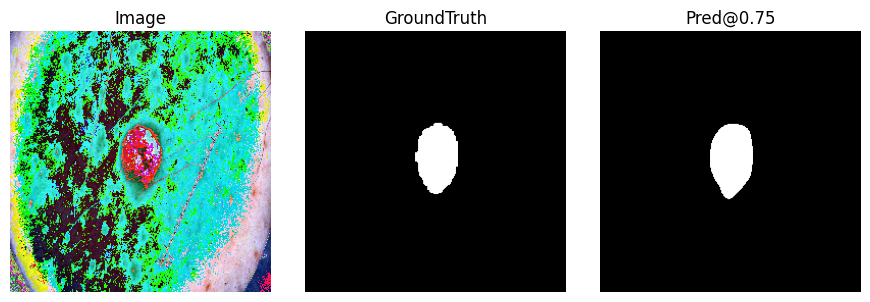

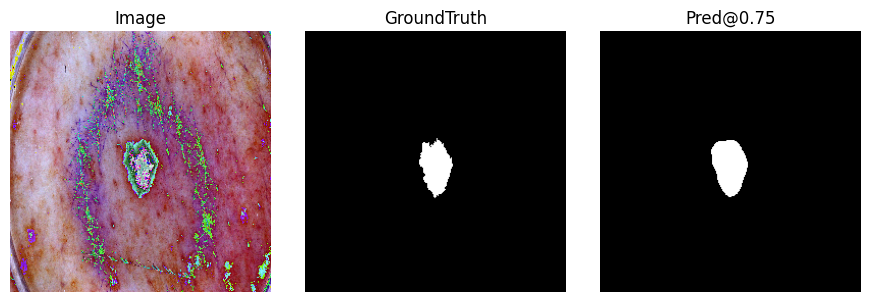

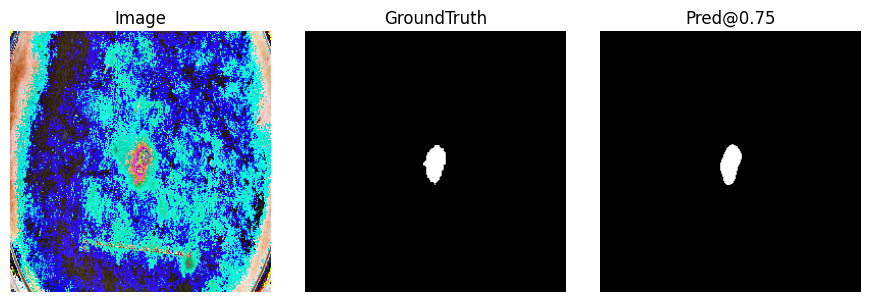

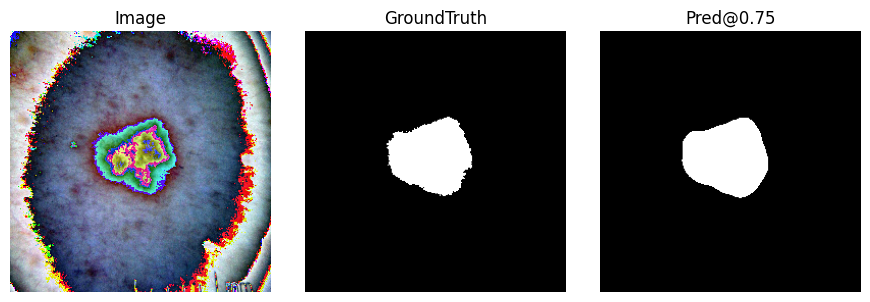

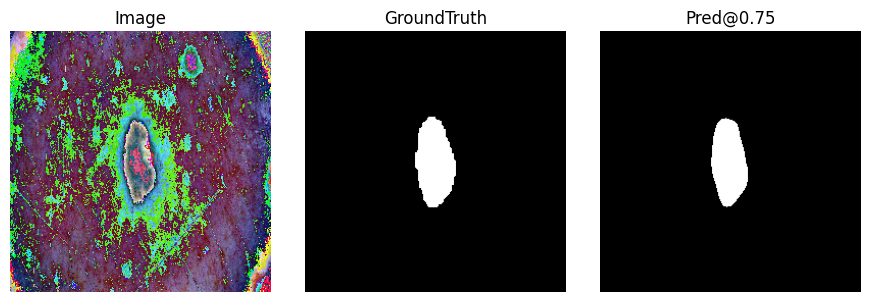

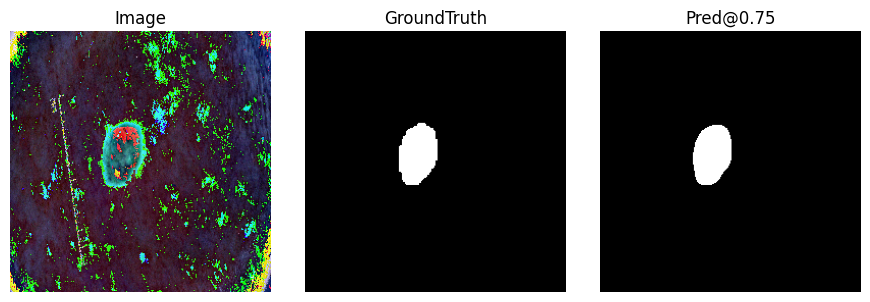

In [ ]:
@torch.no_grad()
def visualize_samples(model, loader, thr=0.5, num=6):
    model.eval()
    cnt = 0
    for imgs, masks in loader:
        imgs = imgs.to(DEVICE)
        probs = torch.sigmoid(model(imgs)).cpu().numpy()
        imgs = imgs.cpu().numpy().transpose(0,2,3,1)
        masks = masks.numpy().transpose(0,2,3,1)
        for i in range(len(imgs)):
            if cnt >= num: return
            img = (imgs[i]*255).astype(np.uint8)
            gt  = (masks[i]*255).astype(np.uint8).squeeze(-1)
            pred = (probs[i,0] > thr).astype(np.uint8)*255
            fig = plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
            plt.subplot(1,3,2); plt.title("GroundTruth"); plt.imshow(gt, cmap="gray"); plt.axis("off")
            plt.subplot(1,3,3); plt.title(f"Pred@{thr:.2f}"); plt.imshow(pred, cmap="gray"); plt.axis("off")
            plt.tight_layout()
            plt.show()
            cnt += 1

visualize_samples(model, test_loader, thr=float(BEST_THR), num=6)
